In [0]:
import random

import cv2
import numpy as np
from matplotlib import pyplot as plt

from tensorflow.keras.layers import Dense, Dropout, Input,LeakyReLU, Embedding, multiply, Flatten, Activation, BatchNormalization
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.datasets import mnist
from tqdm import tqdm_notebook
from tensorflow.keras.optimizers import Adam

In [0]:
def show_image_plt(image):
    plt.figure(figsize=(8, 8))
    if image.ndim == 2:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image[...,::-1])
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [0]:
CHAR = '?'
IMAGE_SHAPE = (32, 32)

In [0]:
fonts = [cv2.FONT_HERSHEY_COMPLEX,
         cv2.FONT_HERSHEY_COMPLEX_SMALL,
         cv2.FONT_HERSHEY_DUPLEX,
         cv2.FONT_HERSHEY_PLAIN,
         cv2.FONT_HERSHEY_SCRIPT_COMPLEX,
         cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,
         cv2.FONT_HERSHEY_SIMPLEX,
         cv2.FONT_HERSHEY_TRIPLEX,
         cv2.FONT_ITALIC]
random_config =  {'img_percent_range': (.6, 0.9),
                  'center_shift_range': (0.2, 0.3),
                  'angle_range': (-20, 20)}

In [0]:
def char_generator(random_config):
    h, w = IMAGE_SHAPE
    canvas = np.zeros(shape=IMAGE_SHAPE, dtype=np.uint8)
    angle = np.random.randint(*random_config['angle_range'])
    shift_x, shift_y = np.random.uniform(*random_config['center_shift_range'], size=2)
    size = np.random.uniform(*random_config['img_percent_range'])
    
    font = random.choice(fonts)
    font_size = np.min([size * w / cv2.getTextSize(CHAR, font, 1, 1)[0][0],
                        size * h / cv2.getTextSize(CHAR, font, 1, 1)[0][1]])
    new_size = cv2.getTextSize(CHAR, font, font_size, 1)
    
    img = cv2.putText(canvas, 
                      CHAR, 
                      (np.round(shift_x * (w - new_size[0][0])).astype(np.int32),
                       np.round(h - shift_y * (h - new_size[0][1])).astype(np.int32)), 
                      fontFace=font,
                      fontScale=font_size,
                      color=(255, 255, 0),
                      thickness=1,
                      lineType=cv2.LINE_AA)
    M = cv2.getRotationMatrix2D((w / 2, h / 2), angle, 1)
    img = cv2.warpAffine(img, M, (w, h))
    return img

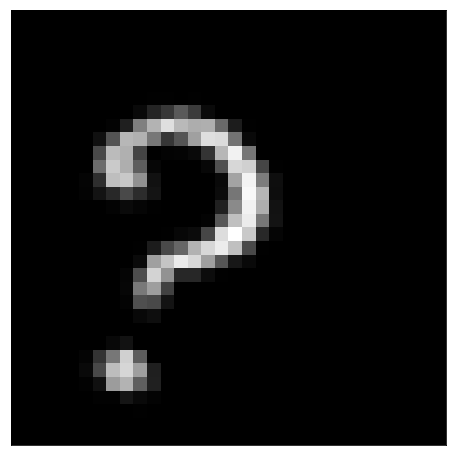

In [6]:
show_image_plt(char_generator(random_config))

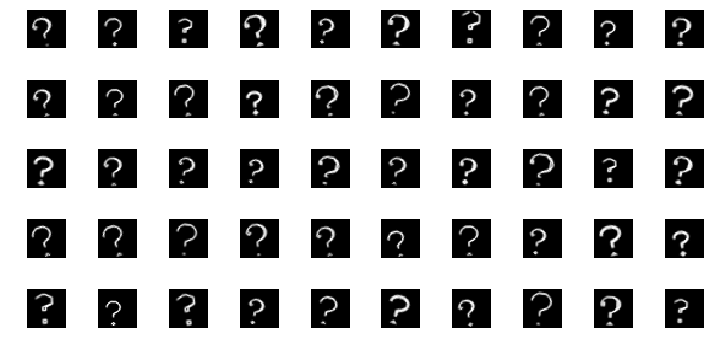

In [7]:
rows, cols = 5, 10
plt.figure(figsize=(cols, rows))
for i in range(rows * cols):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(char_generator(random_config), cmap='gray')
    plt.axis('off')
plt.tight_layout()

In [0]:
def real_batch_generator(batch_size=16):
    output_shape = (batch_size, np.prod(IMAGE_SHAPE))
    output = np.zeros(shape=output_shape, dtype=np.float32)
    for i in range(batch_size):
        img = char_generator(random_config).astype(np.float32)
        img = np.reshape(img, newshape=(np.prod(IMAGE_SHAPE)))
        output[i, ...] = img
    output = (output - 127.5) / 127.5
    return output, np.ones(shape=batch_size) * .9

In [0]:
latent_dim=100

In [10]:
def get_generator():
    
    input_noise = Input(shape=(latent_dim,), name='input_noise')
    
    x = Dense(units=256, input_dim=latent_dim)(input_noise)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    
    x = Dense(units=512)(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    
    x = Dense(units=1024)(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
       
    x = Dense(units=np.prod(IMAGE_SHAPE), activation='tanh')(x)    
    
    model = Model(inputs=input_noise, outputs=x)
    
    return model

g = get_generator()

W0614 03:58:16.389495 140180938332032 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [11]:
def get_discriminator():
    
    input_image = Input(shape=(np.prod(IMAGE_SHAPE),), name='input_image')
    
    x = Dense(units=1024)(input_image)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.3)(x)    
   
    x = Dense(units=512)(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.3)(x)
       
    x = Dense(units=256)(x)
    x = LeakyReLU(0.2)(x)
    
    x = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=input_image, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
    return model

d = get_discriminator()
d.summary()

W0614 03:58:16.942579 140180938332032 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 1024)]            0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0   

In [12]:
def create_gan(discriminator, generator):
    discriminator.trainable=False
    
    input_noise = Input(shape=(latent_dim,))
    
    x = generator(inputs=input_noise)
    gan_output = discriminator(x)
    
    gan = Model(inputs=input_noise, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan
gan = create_gan(d, g)
gan.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
model (Model)                (None, 1024)              1739520   
_________________________________________________________________
model_1 (Model)              (None, 1)                 1705985   
Total params: 3,445,505
Trainable params: 1,735,936
Non-trainable params: 1,709,569
_________________________________________________________________


In [0]:
def plot_generated_images(generator, dim=(5, 5), figsize=(5, 5)):
    noise = np.random.normal(loc=0, scale=1, size=[np.prod(dim), latent_dim])
    generated_images = generator.predict(noise)
    generated_images = 0.5 * generated_images + 0.5
    generated_images = generated_images.reshape(np.prod(dim), *IMAGE_SHAPE)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(*dim, i + 1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [0]:
batch_size = 32
epochs = 500 
steps_per_epoch = 2000

In [0]:
generator = get_generator()
discriminator = get_discriminator()
gan = create_gan(discriminator, generator)

Epoch 1


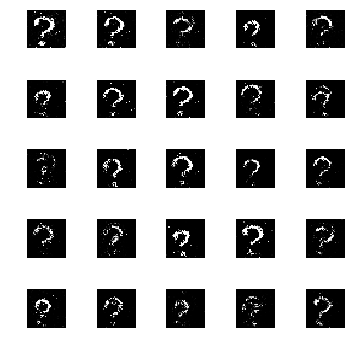

Epoch 2



Epoch 3



Epoch 4



Epoch 5



Epoch 6



Epoch 7



Epoch 8



Epoch 9



Epoch 10



Epoch 11



Epoch 12



Epoch 13



Epoch 14



Epoch 15



Epoch 16



Epoch 17



Epoch 18



Epoch 19



Epoch 20


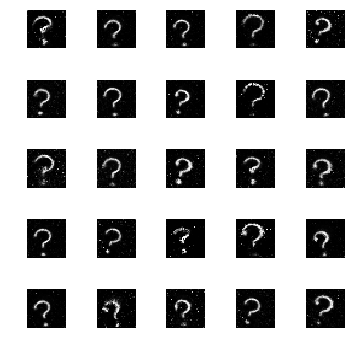

Epoch 21



Epoch 22



Epoch 23



Epoch 24



Epoch 25



Epoch 26



Epoch 27



Epoch 28



Epoch 29



Epoch 30



Epoch 31



Epoch 32



Epoch 33



Epoch 34



Epoch 35



Epoch 36



Epoch 37



Epoch 38



Epoch 39



Epoch 40


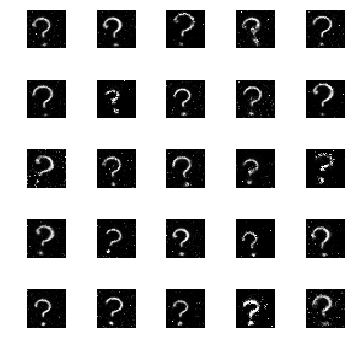

Epoch 41



Epoch 42



Epoch 43



Epoch 44



Epoch 45



Epoch 46



Epoch 47



Epoch 48



Epoch 49



Epoch 50



Epoch 51



Epoch 52



Epoch 53



Epoch 54



Epoch 55



Epoch 56



Epoch 57



Epoch 58



Epoch 59



Epoch 60


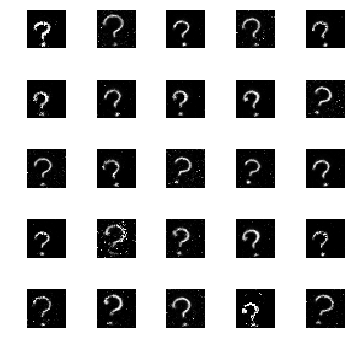

Epoch 61



Epoch 62



Epoch 63



Epoch 64



Epoch 65



Epoch 66



Epoch 67



Epoch 68



Epoch 69



Epoch 70



Epoch 71



Epoch 72



Epoch 73



Epoch 74



Epoch 75



Epoch 76



Epoch 77



Epoch 78



Epoch 79



Epoch 80


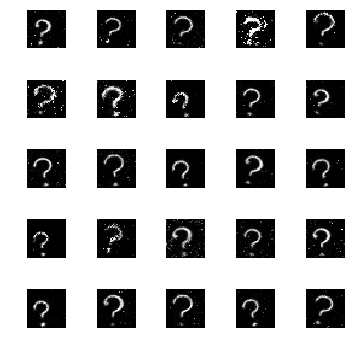

Epoch 81



Epoch 82



Epoch 83



Epoch 84



Epoch 85



Epoch 86



Epoch 87



Epoch 88



Epoch 89



Epoch 90



Epoch 91



Epoch 92



Epoch 93



Epoch 94



Epoch 95



Epoch 96



Epoch 97



Epoch 98



Epoch 99



Epoch 100


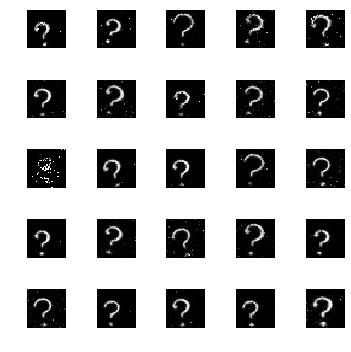

Epoch 101



Epoch 102



Epoch 103



Epoch 104



Epoch 105



Epoch 106



Epoch 107



Epoch 108



Epoch 109



Epoch 110



Epoch 111



Epoch 112


In [0]:
for e in range(1, epochs + 1):
    print("Epoch %d" %e)
    for _ in tqdm_notebook(range(steps_per_epoch)):
        #generate  random noise as an input  to  initialize the  generator
        noise = np.random.normal(0, 1, [batch_size, latent_dim])
        
        # Generate fake '?' images from noised input
        generated_images = generator.predict(noise)
        generated_labels = np.zeros(shape=batch_size)
            
        # Get a random set of real images        
        image_batch, image_batch_labels = real_batch_generator(batch_size=batch_size)
            
        #Construct different batches of  real and fake data 
        X = np.concatenate([image_batch, generated_images])
        y = np.concatenate([image_batch_labels, generated_labels])
                      
        #Pre train discriminator on  fake and real data  before starting the gan. 
        discriminator.trainable=True
        discriminator.train_on_batch(X, y)
            
        #Tricking the noised input of the Generator as real data
        noise = np.random.normal(0, 1, [batch_size, latent_dim])
        fake_labels = np.ones(batch_size)
            
        # During the training of gan, 
        # the weights of discriminator should be fixed. 
        # We can enforce that by setting the trainable flag
        discriminator.trainable=False

        # training  the GAN by alternating the training of the Discriminator 
        # and training the chained GAN model with Discriminator’s weights freezed.
        gan.train_on_batch(noise, fake_labels)        
    if e == 1 or e % 20 == 0:
        plot_generated_images(generator)
        gan.save('gan.hdf5')
        generator.save('generator.hdf5')
        discriminator.save('discriminator.hdf5')